In [1]:
import torch
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import cv2
import os
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import re
import tqdm

%matplotlib inline
plt.style.use('bmh')
torch.manual_seed(18)
torch.set_default_tensor_type('torch.FloatTensor')
g_cuda = torch.Generator(device='cuda')

In [2]:
file= []
dir = []
def list_dir(start_dir):
    dir_res = os.listdir(start_dir)
    for path in dir_res:
        temp_path = start_dir + '/' + path
        if os.path.isfile(temp_path):
            file.append(temp_path)
        if os.path.isdir(temp_path):
            dir.append(temp_path)
            list_dir(temp_path)

# 721 images
list_dir("/home/f.yang1/CAP5404/Part2/ColorfulOriginal//")
file.sort()

In [3]:
train_data = file[:-50]
test_data = file[-50:]

In [4]:
class Train_Dataset(Dataset):
    def __init__(self):
        self.input_data = train_data
        
    def __getitem__(self, index):
        img = cv2.imread(self.input_data[index])
        img = cv2.resize(img,(128,128))
        LAB = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
        L1,a1,b1 = cv2.split(LAB)
        X = transforms.ToTensor()(L1).cuda()
        y1 = torch.from_numpy(np.array(a1)).cuda()
        y2 = torch.from_numpy(np.array(b1)).cuda()
        y = torch.stack((y1,y2))
        return X, y

    def __len__(self):
        return len(self.input_data)
    
class Test_Dataset(Dataset):
    def __init__(self):
        self.dataset = test_data
        
    def __getitem__(self, index):
        img = cv2.imread(self.dataset[index])
        img = cv2.resize(img,(128,128))

        img = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
        L2,a2,b2 = cv2.split(img)
        X = transforms.ToTensor()(L2).cuda()
        y1 = torch.from_numpy(np.asarray(a2)).cuda()
        y2 = torch.from_numpy(np.asarray(b2)).cuda()
        y = torch.stack((y1,y2))

        return X, y

    def __len__(self):
        return len(self.dataset)

In [5]:
# train input [batch size, 1, 128,128] label [batch size, 2,128,128]
Train_data = Train_Dataset()
Train_Dataloader = DataLoader(Train_data,batch_size=1,shuffle = True,drop_last=True)

# test input [batch size, 1, 128,128] label [batch size, 2,128,128]
Test_data = Test_Dataset()
Test_Dataloader = DataLoader(Test_data,batch_size=1)

In [6]:
a = torch.rand(1,1,240,362)
net =  nn.Conv2d(in_channels=1,out_channels=3,kernel_size=3,stride=2,padding=1)
net(a).shape

torch.Size([1, 3, 120, 181])

In [7]:
class DownsampleLayer(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(DownsampleLayer, self).__init__()
        self.downsample=nn.Sequential(
            nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
    def forward(self,x):
        out=self.downsample(x)
        return out

In [8]:
class UpSampleLayer(nn.Module):
    def __init__(self,in_ch,out_ch,last = False):
        super(UpSampleLayer, self).__init__()
        if last:
            self.upsample=nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=2,padding=1,output_padding=1),
            )
        else:
            self.upsample=nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=2,padding=1,output_padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU()
            )
    def forward(self,x):
        x_out=self.upsample(x)
        return x_out

In [9]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        out_channels=[2**(i+5) for i in range(5)]
        # down
        self.d1=DownsampleLayer(1,out_channels[0])
        self.d2=DownsampleLayer(out_channels[0],out_channels[1])
        self.d3=DownsampleLayer(out_channels[1],out_channels[2])
        self.d4=DownsampleLayer(out_channels[2],out_channels[3])
        self.d5=DownsampleLayer(out_channels[3],out_channels[4])

        # up
        self.u1=UpSampleLayer(out_channels[4],out_channels[3])
        self.u2=UpSampleLayer(out_channels[3],out_channels[2])
        self.u3=UpSampleLayer(out_channels[2],out_channels[1])
        self.u4=UpSampleLayer(out_channels[1],out_channels[0])
        self.u5=UpSampleLayer(out_channels[0], 2, last= True)

    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)
        d5 = self.d5(d4)
        u1 = self.u1(d5)
        u2 = self.u2(u1)
        u3 = self.u3(u2)
        u4 = self.u4(u3)
        u5 = self.u5(u4)
        
        return u5
        
        
# def init_weights(layer):

#     if type(layer) == nn.Conv2d:
#         nn.init.normal_(layer.weight, mean=0, std=0.5)
        
# net = CNN().cuda()
# net.apply(init_weights)

In [10]:
net = torch.load("colorization.pt").cuda()
# net = CNN().cuda()

In [11]:
loss = nn.SmoothL1Loss().cuda()
trainer = torch.optim.Adam(net.parameters(), lr=0.01)
num_epochs = 5
loss_item = []
for epoch in tqdm.tqdm(range(num_epochs)):
    for X,y in Test_Dataloader:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
        loss_item.append(l.cpu().item())
#     print(l)

100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Text(0, 0.5, 'SmoothL1Loss')

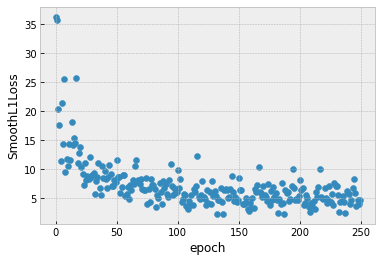

In [12]:
len(loss_item)
x = [i for i in range(250)]
plt.scatter(x,loss_item)
plt.xlabel("epoch")
plt.ylabel("SmoothL1Loss")

In [13]:
net.eval()
test_loss = nn.MSELoss().cuda()
for X,y in Test_Dataloader:
    with torch.no_grad(): 
        output = net(X.float()) 
    MSE = test_loss(y,output).item()
print("CNN: on the test dataset MSE = {}".format(MSE))

CNN: on the test dataset MSE = 74.2396240234375


In [17]:
Test_data = Test_Dataset()
Test_Dataloader = DataLoader(Test_data,batch_size=1,shuffle = True)

net.eval()
test_loss = nn.MSELoss().cuda()
i=0
for X,y in Test_Dataloader:
    with torch.no_grad(): 
        output = net(X.float()) 
        MSE = test_loss(y,output).item()
        output = output.squeeze().cpu().numpy()
        output = output.transpose(1,2,0)
        a,b = np.array(cv2.split(output)).astype('uint8')
        L = X.reshape(128,128).cpu().numpy()*255
        L = L.astype('uint8')
        LAB = np.stack([L,a,b])
        LAB = LAB.transpose(1,2,0)
        RGB_img = cv2.cvtColor(LAB,cv2.COLOR_LAB2BGR)
        cv2.imwrite("results_img/fruit{}.jpg".format(i),RGB_img)
        i+=1
print("CNN: on the test dataset MSE = {}".format(MSE))

CNN: on the test dataset MSE = 84.63421630859375


In [116]:
output = output.squeeze().cpu().numpy()
output = output.transpose(1,2,0)
a,b = np.array(cv2.split(output)).astype('uint8')
L = X.reshape(128,128).cpu().numpy()*255
L = L.astype('uint8')
LAB = np.stack([L,a,b])
LAB = LAB.transpose(1,2,0)
RGB_img = cv2.cvtColor(LAB,cv2.COLOR_LAB2RGB)

True

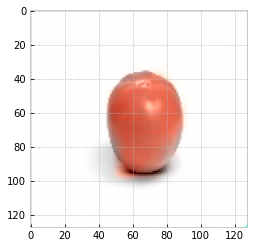

In [127]:
plt.imshow(RGB_img)
cv2.imwrite("1.jpg",RGB_img)

In [126]:
import math
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
img = cv2.imread(test_data[0])
img = cv2.resize(img,(128,128))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB).astype('uint8')
measure = psnr(RGB_img,img)
print("on this test image PSNR = {}".format(measure))

on this test image PSNR = 30.109025873306
